In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import physical_constants
from scipy.integrate import nquad

from ries.constituents.isotope import Isotope
from ries.constituents.state import GroundState, State
from ries.constituents.element import natural_elements
from ries.resonance.debye_model import effective_temperature_debye_approximation, room_temperature_T_D
from ries.resonance.voigt import Voigt
from ries.nonresonant.xrmac import load_xrmac_data, xrmac_fm2_per_atom
load_xrmac_data()

/home/udo/.local/lib/python3.10/site-packages/ries-1.0.1-py3.10.egg/ries/nonresonant/xrmac.py:297: UserWarning: X-ray mass attenuation coefficient (XRMAC) data for the following elements were not found in '/home/udo/.local/lib/python3.10/site-packages/ries-1.0.1-py3.10.egg/ries/nonresonant/../nonresonant/nist_xrmac' and replaced by an analytical expression for the Compton-scattering cross section:
H, He, Li, Be, B, C, N, O, F, Ne, Na, Mg, Al, Si, P, S, Cl, Ar, K, Ca, Sc, Ti, V, Cr, Mn, Fe, Co, Ni, Cu, Zn, Ga, Ge, As, Se, Br, Kr, Rb, Sr, Y, Zr, Nb, Mo, Tc, Ru, Rh, Pd, Ag, Cd, In, Sn, Sb, Te, I, Xe, Cs, Ba, La, Ce, Pr, Nd, Pm, Sm, Eu, Gd, Tb, Dy, Ho, Er, Tm, Yb, Lu, Hf, Ta, W, Re, Os, Ir, Pt, Au, Hg, Tl, Pb, Bi, Po, At, Rn, Fr, Ra, Ac, Th, Pa, U
Please note that the Compton-scattering cross section is only a rough approximation of the true XRMAC.
  warn(warning_message)


# Self-absorption Correction

As indicated in `RIES_DIR/README.md`, the number of reactions in a beam-on-target experiment is only proportional to the areal density of the target if it is sufficiently thin.
Otherwise, a significant amount of beam particles will already have reacted before they can reach the end of the target.

This notebook shows how to obtain the dependence of the reaction rate on the areal density of a target, which helps to optimize target dimensions or correct for the self-absorption effect.
The notation is similar to the dissertation of C. Romig [1].

## Example Case

Consider a nuclear resonance fluorescence (NRF) experiment with a photon beam on the $1^+$ state of $^{12}$C at an excitation energy of 15.110 MeV.
In the vicinity of the resonance, the beam will be attenuated in the target due to nonresonant (Compton scattering, electron-positron pair production, Rayleigh scattering, ...) reactions and resonant absorption on the 15.110-MeV state.
The former is usually known as "x-ray attenuation" [2], while the latter resonant attenuation is called the self-absorption effect.

The example uses realistic target dimensions from an experiment at the High Intensity Gamma-Ray Source (HIγS) [3].
Graphite is almost chemically pure in carbon, and natural carbon is almost isotopically pure in $^{12}$C, which is one of very few nuclei with a strong, well-isolated electromagnetic resonance at such a high energy.
Therefore, this experiment used an available cylindric graphite piece, cut from a larger rod, as a calibration standard.
As will be seen below, the target size and the cross section were large enough to create a significant self-absorption effect.

## Definitions

Properties of the $^{12}$C nucleus and the graphite target.
All nuclear data are taken from the Nuclear Data Sheets [4].
Remember that `ries` uses `ℏc = 197.3269804 MeV fm` and Kelvin as the unit of temperature.

In [2]:
ground_state_width = 43.6e-6
ground_state_relative_width = 100./(100.+1.5+4.2+2.83+2.49)

c12 = Isotope("12C",
        natural_elements["C"].isotopes["12C"].amu,
        ground_state=GroundState("0^+_1", two_J=0, parity=1),
        excited_states={
            "1^+": State(
                "1^+", two_J=2, parity=1, 
                excitation_energy=15.110,
                # The 15.110-MeV state mainly decays to the ground state, but other decay branches
                # are known.
                # Here, only the "elastic" NRF reaction is of interest, i.e. only the ground-state 
                # transition width is given explicitly, all other transitions widths are simply
                # summarized as 'rest' to get the correct total width.
                partial_widths={
                    "0^+_1": ground_state_relative_width*ground_state_width,
                    "rest": (1.-ground_state_relative_width)*ground_state_width,
                }
            )
        }
       )

sigma_r = Voigt(
    initial_state=c12.ground_state,
    intermediate_state=c12.excited_states['1^+'],
    amu=c12.amu,
    # The choice of the Debye approximation for the effective temperature, and the estimate for the
    # room temperature, do not significantly impact the final result, because the total width of
    # the 15.110-MeV state is much larger than the Doppler width.
    effective_temperature=effective_temperature_debye_approximation(293., room_temperature_T_D["C"]),
)
xrmac = xrmac_fm2_per_atom["C"]

mass = 24.9e-3 # kg
radius = 0.5*25.4e-3*1e15 # fm (the target diameter is 1 inch)
areal_density = (
    mass
    /(
        natural_elements["C"].amu
        *physical_constants["atomic mass constant"][0])
    /(np.pi*radius**2)
) # number of carbon nuclei per fm^2

## Plot Cross Section

For this excited state and at room temperature, the Doppler width is as large as the width of the excited state:

In [3]:
sigma_r.probability_distribution.doppler_width/sigma_r.intermediate_state.width

1.06432548282162

Therefore, the resonance shape is in between a Breit-Wigner (Cauchy) and a normal distribution.

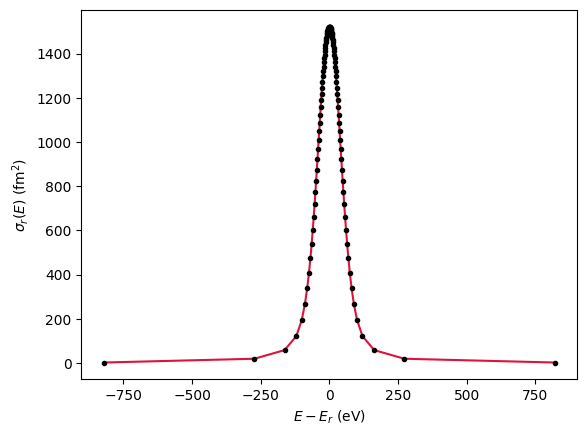

In [4]:
energies = sigma_r.equidistant_probability_grid(0.99, 100)
cross_section = sigma_r(energies)

fig, ax = plt.subplots(1,1)
ax.set_xlabel("$E - E_r$ (eV)")
ax.set_ylabel("$\sigma_r(E)$ (fm$^2$)")
ax.plot(
    (energies-c12.excited_states["1^+"].excitation_energy)*1e6,
    cross_section, "-", color="crimson"
)
# Show the sampled points as black dots.
# This illustrates how the equidistant-probability grid is finer around the maximum.
ax.plot(
    (energies-c12.excited_states["1^+"].excitation_energy)*1e6,
    cross_section, ".", color="black"
)

## Resonance Absorption Density

If ...

* ... the incoming beam is parallel, and the dependence of its energy- and intensity distribution on the transversal axes is negligible,
* ... the target is homogenous and rotationally symmetric along the beam axis,
* ... higher-order effects like "notch refilling" [5] are negligible,

the dependence of the energy-differential photon flux $\mathrm{d} \Phi / \mathrm{d} E$ (number of photons per unit area and time interval) on the areal density $\rho$ (number of nuclei per unit area that have been traversed by the beam) is given by the differential equation [6]:

$\frac{\mathrm{d} \Phi}{\mathrm{d} E \mathrm{d} \rho} (E, \rho) = -\left[ \sigma_r \left( E \right) + \sigma_{nr} \left( E \right) \right] \frac{\Phi}{\mathrm{d} E} (E, \rho)$.

Here, $\sigma_\mathrm{r}$ and $\sigma_\mathrm{nr}$ denote the resonant and the nonresonant cross sections, respectively.
The solution of this equation is:

$\frac{\mathrm{d} \Phi}{\mathrm{d} E} (E, \rho) = \Phi \left( E, \rho = 0 \right) \exp \lbrace - \left[ \sigma_r \left( E \right) + \sigma_{nr} \left( E \right) \right] \rho \rbrace$.

Using the definition of this "photon-flux density" $\mathrm{d} \Phi / \mathrm{d} E$, the NRF reaction rate per unit area $N_\mathrm{NRF}$ is given by:

$N_\mathrm{NRF} = \int_0^\infty \int_0^{\rho_t} \underbrace{\sigma_r (E) \frac{\mathrm{d} \Phi}{\mathrm{d} E} (E, \rho)}_{\alpha (E, \rho)} \mathrm{d} \rho \mathrm{d} E$.

Here, $\rho_t$ denotes the total areal density of the target.
In reality, the intensity of the beam decreases as it penetrates the target, while the resonance cross section stays the same.
An alternative interpretation keeps the beam intensity constant, and assumes that the cross section varies with the penetration depth.
The integrand of the equation above, denoted as $\alpha$, is also called the "resonance absorption density", and it gives the energy- and penetration-depth dependence of the cross section.

A thin target is defined by the inequality:

$\left[ \sigma_r \left( E \right) + \sigma_{nr} \left( E \right) \right] \rho_t \ll 1$

$\forall E$,

which means that the exponential term evalues to $1$.

In the present example, the target does not only contain the isotope of interest, but also $^{13}$C.
While both isotopes contribute to the nonresonant attenuation, only $^{12}$C can resonantly absorb photons in the vicinity of its resonance.
Here, the areal density of all carbon nuclei is used as a variable, which means that the nonresonant cross section is the x-ray mass attenuation cross section (converted from the mass attenuation coefficient of Ref. [2]) for natural carbon, while the resonance cross section must be multiplied by the relative abundance of $^{12}$C.

The following code defines the realistic resonance absorption density and the thin-target approximation.

In [5]:
def alpha(energy, areal_density):
    """Resonance absorption density
    
Parameters
----------
energy: float or ndarray
    Photon energy in MeV.
areal_density: float or ndarray
    Number of nuclei per unit area that have been traversed by the beam in fm^-2.
    
Returns
-------
float or ndarray
    Resonance absorption density in fm^2.
    """
    return (
        sigma_r(energy)
        *np.exp(
            -(
                natural_elements["C"].abundances["12C"]*sigma_r(energy) # Only 12C contributes to the resonant absorption
                +xrmac(energy) # All isotopes contribute to the nonresonant attenuation
            )*areal_density
        )
    )

def alpha_thin_target_approximation(energy, areal_density):
    """Resonance absorption density in the thin-target approximation
    
See the definition of alpha().
    """
    return sigma_r(energy)

## Plot resonance absorption densities

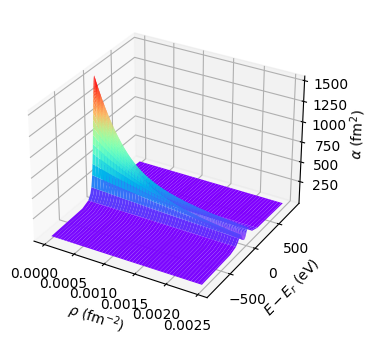

In [6]:
areal_densities = np.linspace(0., areal_density, 100)

areal_densities_2d, energies_2d = np.meshgrid(
    areal_densities, energies
)

alpha_plot = alpha(energies_2d, areal_densities_2d)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel(r"$\rho$ (fm$^{-2}$)")
ax.set_ylabel(r"$E - E_r$ (eV)")
ax.set_zlabel(r"$\alpha$ (fm$^2$)")
ax.plot_surface(
    areal_densities_2d,
    (energies_2d-c12.excited_states["1^+"].excitation_energy)*1e6,
    alpha_plot,
    cmap="rainbow"
)

Thin-target approximation

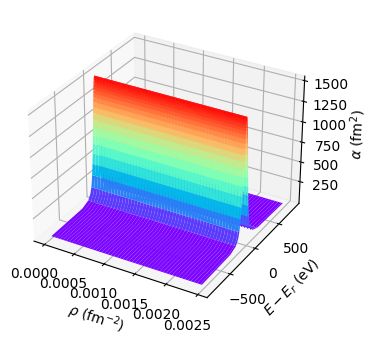

In [7]:
alpha_thin_target_approximation_plot = alpha_thin_target_approximation(energies_2d, areal_densities_2d)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel(r"$\rho$ (fm$^{-2}$)")
ax.set_ylabel(r"$E - E_r$ (eV)")
ax.set_zlabel(r"$\alpha$ (fm$^2$)")
ax.plot_surface(
    areal_densities_2d,
    (energies_2d-c12.excited_states["1^+"].excitation_energy)*1e6,
    alpha_thin_target_approximation_plot,
    cmap="rainbow"
)

## Calculate reaction rate

The two-dimensional integral over $\alpha$ has to be solved numerically.
Here, `scipy.integrate.nquad` is used.
The integral is evaluated for several different areal densities up to the actual value, to get a
plot of the reaction rate versus the areal density.

In [8]:
areal_densities_1d = np.linspace(0.001*areal_density, areal_density, 10)

n_nrf = np.zeros(len(areal_densities_1d))
n_nrf_approx = np.zeros(len(areal_densities_1d))

for i in range(len(areal_densities_1d)):    
    n_nrf[i] = nquad(alpha, 
                  [
                      [energies[0], energies[-1]],
                      [0., areal_densities_1d[i]]
                  ]
                 )[0]
    n_nrf_approx[i] = nquad(alpha_thin_target_approximation, 
                  [
                      [energies[0], energies[-1]],
                      [0., areal_densities_1d[i]]
                  ]
                 )[0]

## Plot results

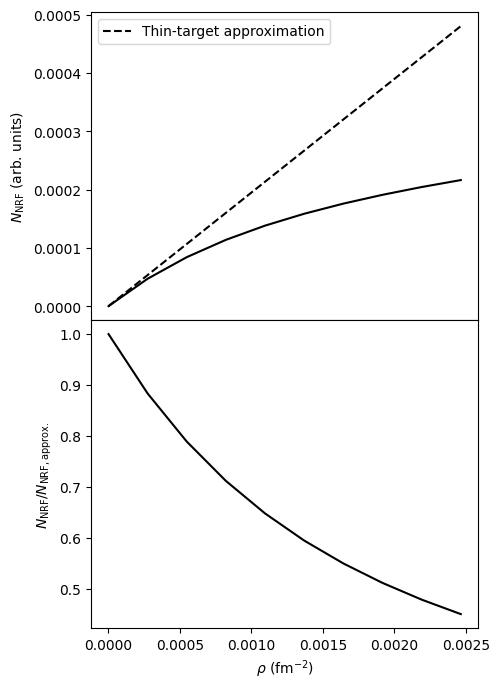

In [9]:
fig, ax = plt.subplots(2,1, figsize=(5,8))
fig.subplots_adjust(hspace=0)
ax[0].set_xticks([])
ax[0].set_ylabel("$N_\mathrm{NRF}$ (arb. units)")
ax[0].plot(areal_densities_1d, n_nrf, color="black")
ax[0].plot(areal_densities_1d, n_nrf_approx,
           "--", color="black", label="Thin-target approximation")
ax[0].legend()

ax[1].set_xlabel(r"$\rho$ (fm$^{-2}$)")
ax[1].set_ylabel("$N_\mathrm{NRF} / N_\mathrm{NRF, approx.}$")
ax[1].plot(areal_densities_1d, n_nrf/n_nrf_approx, color="black")


## References

[1] C. Romig, Investigation of Nuclear Structure with Relative Self-Absorption Measurements, Dissertation, TU Darmstadt (2015) (https://tuprints.ulb.tu-darmstadt.de/id/eprint/4446)

[2] J. H. Hubbell and S. M. Seltzer, Tables of X-Ray Mass Attenuation Coefficients and Mass Energy-Absorption Coefficients from 1 keV to 20 MeV for Elements Z=1 to 92 and 48 Additional Substances of Dosimetric Interest, National Institute of Standards and Technology (NIST), NISTIR 5632 (2004) https://dx.doi.org/10.18434/T4D01F

[3] High-Intensity Gamma-Ray Source (HIγS) at TUNL https://tunl.duke.edu/research/our-facilities, accessed on 05/28/2020
    
[4] J. H. Kelley, J. E. Purcell, C. G. Sheu, Energy levels of light nuclei $A=12$, Nucl. Phys. A **968** (2017) https://doi.org/10.1016/j.nuclphysa.2017.07.015
    
[5] Notch refilling means that high-energy photons can be scattered at small angles and replenish the photon flux at lower energies.
Since this effect requires a nonresonant-scattering process and an absorption, it can be considered a higher-order effect.
The probability not only depends on the areal density, but also on the topology of the target.
More information can be found in Refs. [6, 7].
In the differential equation above, notch refilling would add a term with a positive sign.

[6] J. Pruet, D. P. McNabb, C. A. Hagmann, F. V. Hartemann, and C. P. J. Barty, Detecting clandestine material with nuclear resonance fluorescence, J. Appl. Phys. **99**, 123102 (2006) https://doi.org/10.1063/1.2202005

[7] J. R. Vavrek, B. S. Henderson, and A. Danagoulian, Validation of Geant4's G4NRF module against nuclear resonance fluorescence data from $^{238}$U and $^{27}$Al, Nucl. Instrum. Meth. A **459**, 188 (2019)

[8] U. Friman-Gayer *et al.*, Phys. Rev. Lett. **126**, 102501 (2021) https://doi.org/10.1103/PhysRevLett.126.102501; arXiv:2005.07837 https://arxiv.org/abs/2005.07837